In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("hazemfahmy/openned-closed-eyes")

# print("Path to dataset files:", path)

In [3]:
import os ,random

import numpy as np
import cv2 

from PIL import Image
import matplotlib.pyplot as plt

import string
import warnings

import tensorflow as tf


from tensorflow.keras.models import Sequential


from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


warnings.filterwarnings('ignore')

In [4]:
#Resizing and turning the images in Closed,Opened into numpy method

data = "C:\\Users\\mosta\\.cache\\kagglehub\\datasets\\hazemfahmy\\openned-closed-eyes\\versions\\6\\TrainingSet\\TrainingSet"
Closed_eye_dir = os.path.join(data, "Closed")
Opened_eye_dir = os.path.join(data, "Opened")

Closed_eye = os.listdir(Closed_eye_dir)
Opened_eye = os.listdir(Opened_eye_dir)

X = []
Y = []

for i, image_name in enumerate(Opened_eye):
    image_path = os.path.join(Opened_eye_dir, image_name)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw, channels=3)
    image_resized = tf.image.resize(image, [64, 64])
    X.append(image_resized.numpy())
    Y.append(0)

for i, image_name in enumerate(Closed_eye):
    image_path = os.path.join(Closed_eye_dir, image_name)
    image_raw = tf.io.read_file(image_path)
    image = tf.image.decode_image(image_raw, channels=3)
    image_resized = tf.image.resize(image, [64, 64])
    X.append(image_resized.numpy())
    Y.append(1)

X = np.array(X)
Y = np.array(Y)
print("Data Shape after resizing:", X.shape)

Data Shape after resizing: (1704, 64, 64, 3)


In [5]:
#Normalization
X = np.clip(X, 0, 255) 
X = X / 255.0
print("Min value :", X.min())  
print("Max value :", X.max())

Min value : 0.0
Max value : 1.0


In [6]:
# Function to apply data augmentation
def augment_image(image):
    image = tf.image.random_flip_left_right(image)  # Flip horizontally
    image = tf.image.random_flip_up_down(image)    # Flip vertically
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    image = tf.image.random_crop(image, size=[48, 48, 3])  # Random crop
    image = tf.image.resize(image, [64, 64])  # Resize back to 64x64
    return image

# Load and augment data
augmented_X = []
augmented_Y = []

for i, (image, label) in enumerate(zip(X, Y)):
    # Convert image to Tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    # Apply augmentation
    augmented_image = augment_image(image_tensor)
    # Append augmented image and label to the new dataset
    augmented_X.append(augmented_image.numpy())
    augmented_Y.append(label)

# Combine original and augmented data
X_augmented = np.array(augmented_X + X.tolist())
Y_augmented = np.array(augmented_Y + Y.tolist())

print("Augmented Data Shape:", X_augmented.shape)
print("Augmented Labels Shape:", Y_augmented.shape)

Augmented Data Shape: (3408, 64, 64, 3)
Augmented Labels Shape: (3408,)


In [7]:
# Define the processing function
def process_images(image_list, image_dir, target_size=(64, 64), apply_histogram_equalization=False):
    processed_images = []
    for image_name in image_list:
        # Full path to the image
        image_path = os.path.join(image_dir, image_name)
        # Load and decode image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw, channels=3)
        image_resized = tf.image.resize(image, target_size).numpy().astype(np.uint8)
        
        # Convert to grayscale
        image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
        
        if apply_histogram_equalization:
            # Apply histogram equalization
            image_gray = cv2.equalizeHist(image_gray)
        
        # Add processed image to the list
        processed_images.append(image_gray)
    
    # Convert to numpy array
    processed_images = np.array(processed_images)
    print(f"Shape after processing: {processed_images.shape}")
    return processed_images

# Process datasets
print("Processing Opened Eyes...")
X_opened = process_images(Opened_eye, Opened_eye_dir, apply_histogram_equalization=True)

print("Processing Closed Eyes...")
X_closed = process_images(Closed_eye, Closed_eye_dir, apply_histogram_equalization=True)

# Combine datasets
X = np.vstack([X_opened, X_closed])
Y = np.array([0] * len(Opened_eye) + [1] * len(Closed_eye))

# Print final dataset shapes
print("Final Dataset Shapes:")
print(f"X shape: {X.shape}")  # Shape of processed images
print(f"Y shape: {Y.shape}")  # Shape of labels


Processing Opened Eyes...
Shape after processing: (824, 64, 64)
Processing Closed Eyes...
Shape after processing: (880, 64, 64)
Final Dataset Shapes:
X shape: (1704, 64, 64)
Y shape: (1704,)


In [8]:


# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Input shape for grayscale images
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),  # Dense layer units
        Dropout(0.5),
        Dense(4, activation='softmax')  # 4 classes: closed, open, yawn, not_yawn
    ])
    return model

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [9]:

x_train , x_temp ,y_train ,y_temp = train_test_split(X,Y,test_size=.4,shuffle=True,random_state=42)
x_test, x_val ,y_test , y_val = train_test_split(x_temp,y_temp,test_size=0.5,shuffle=True , random_state=42)

print(f'Train set: {x_train.shape}, {y_train.shape}') 
print(f'Validation set: {x_val.shape}, {y_val.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

Train set: (1022, 64, 64), (1022,)
Validation set: (341, 64, 64), (341,)
Test set: (341, 64, 64), (341,)


In [10]:

# Assuming X and y are already defined
# Add channel dimension to make it (num_samples, 64, 64, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Verify shapes
print(x_train.shape)  # Should be (1022, 64, 64, 1)
print(x_val.shape)    # Should be (341, 64, 64, 1)
print(x_test.shape)   # Should be (341, 64, 64, 1)
print(y_train.shape)  # Should be (1022, 4)
print(y_val.shape)    # Should be (341, 4)
print(y_test.shape)   # Should be (341, 4)


(1022, 64, 64, 1)
(341, 64, 64, 1)
(341, 64, 64, 1)
(1022, 4)
(341, 4)
(341, 4)


In [11]:

# Define ImageDataGenerators for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator()

# Convert numpy arrays to batches
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_test_datagen.flow(x_val, y_val, batch_size=32)
test_generator = val_test_datagen.flow(x_test, y_test, batch_size=32)


In [12]:

# Train the model with simplified steps
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4491 - loss: 24.5583 - val_accuracy: 0.5865 - val_loss: 0.7014
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5476 - loss: 0.7094 - val_accuracy: 0.6217 - val_loss: 0.6446
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.6233 - loss: 0.6492 - val_accuracy: 0.6716 - val_loss: 0.6549
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6938 - loss: 0.6159 - val_accuracy: 0.6393 - val_loss: 0.7890
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.7129 - loss: 0.5891 - val_accuracy: 0.6305 - val_loss: 0.8562
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.7276 - loss: 0.5446 - val_accuracy: 0.6891 - val_loss: 0.7144
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7812 - loss: 0.4772 - val_accuracy: 0.7097 - val_loss: 0.7624
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7951 - loss: 0.4626 - val_accuracy: 0.6569 -

In [13]:
# # Evaluate the model using the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8957 - loss: 0.3156
Test Loss: 0.292148619890213
Test Accuracy: 0.900293231010437


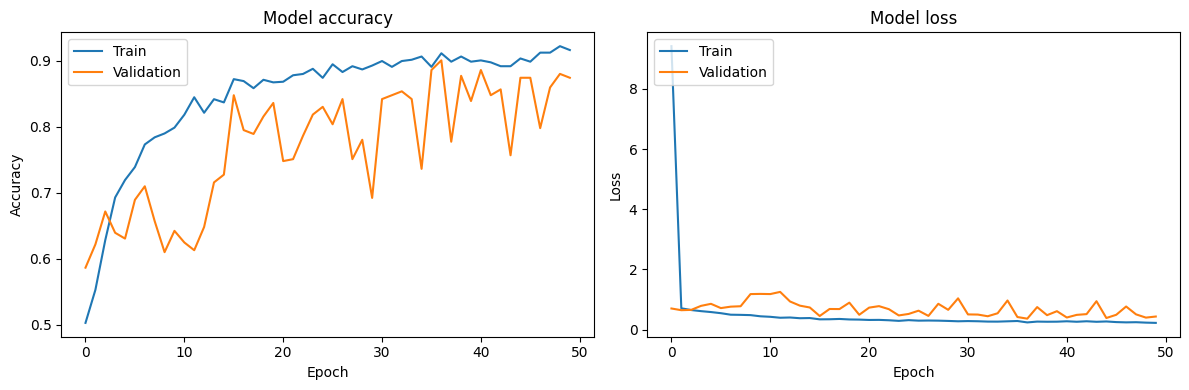

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [15]:
print(f"Number of open images: {len(Opened_eye)}")
print(f"Number of closed images: {len(Closed_eye)}")


Number of open images: 824
Number of closed images: 880


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


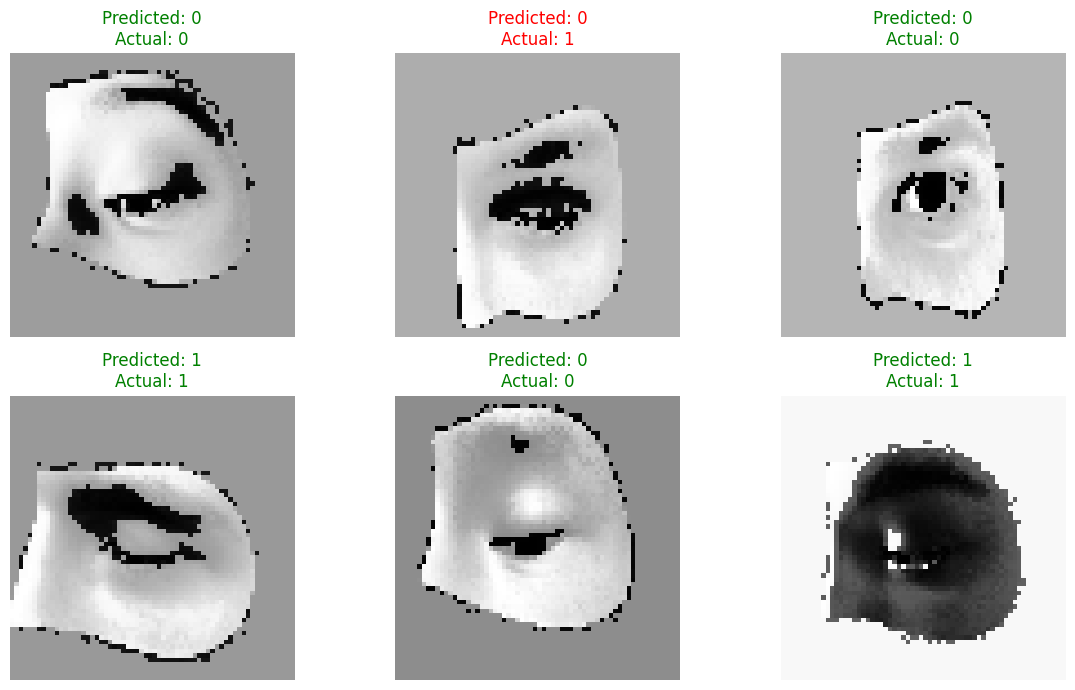

In [ ]:
# Assuming `model` is your trained TensorFlow model and `X_train` is your training data
random_indices = random.sample(range(len(x_train)), 6)

# Create a dataset from selected indices
def load_random_samples(X, indices):
    selected_images = [X[idx] for idx in indices]
    return np.array(selected_images)

random_samples = load_random_samples(x_train, random_indices)

# Predictions
predictions = model.predict(random_samples)
predicted_classes = np.argmax(predictions, axis=1)

# Assuming `y_train` contains the actual labels
actual_labels = [y_train[idx] for idx in random_indices]
actual_classes = np.argmax(actual_labels, axis=1)



fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axs = axes.ravel()

for i in range(6):
    img = random_samples[i].squeeze()  # Squeeze to remove single-dimensional entries
    prediction = predicted_classes[i]
    actual_label = actual_classes[i]
    
    axs[i].imshow(img, cmap='gray')  # Use 'gray' cmap for grayscale images
    
    col = 'green' if actual_label == prediction else 'red'
    axs[i].set_title(f'Predicted: {prediction}\nActual: {actual_label}', color=col)
    axs[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


In [17]:
import pickle
import tensorflow as tf

# # Assuming 'model' is your trained TensorFlow model
# model.save('DDD-model.pkl')

model.save("DDD_model.h5")
print("Model saved as DDD_model.h5")

# with open("DDD-model.pkl", "wb") as pkl_file:
#     pickle.dump(model, pkl_file)
# print("Model saved as fracture.pkl")

Model saved as fracture.h5
Model saved as fracture.pkl


In [26]:
# import tensorflow as tf
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the class labels dictionary
# classes = {
#     0: "open",
#     1: "closed",
# }

# # Path to the image you want to predict
# image_path = 'D:/projects/DeepLearning PY Project/uploaded_images/194.jpg'

# # Read the image using matplotlib
# image = plt.imread(image_path)

# # Resize the image to (64, 64) using OpenCV
# resized_image = cv2.resize(image, (64, 64))

# # Check the model's input shape
# DDD_model = tf.keras.models.load_model("DDD_model.h5")
# print(f"Model input shape: {DDD_model.input_shape}")

# # Preprocess the image according to the model's expected input
# if DDD_model.input_shape[-1] == 3:  # If the model expects RGB
#     input_image = np.expand_dims(resized_image, axis=0)  # Add batch dimension
# elif DDD_model.input_shape[-1] == 1:  # If the model expects grayscale
#     gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
#     gray_image = np.expand_dims(gray_image, axis=-1)  # Add channel dimension
#     input_image = np.expand_dims(gray_image, axis=0)  # Add batch dimension
# else:
#     raise ValueError("Unexpected model input shape!")

# # Validate input shape
# print(f"Input shape for prediction: {input_image.shape}")

# # Predict the class of the image
# predictions = DDD_model.predict(input_image)

# # Convert predicted probabilities to class index
# predicted_class = np.argmax(predictions, axis=1)[0]

# # Retrieve the class label from the dictionary
# predicted_label = classes[predicted_class]

# print(f"Actual Class: closed")
# print(f"Predicted Class: {predicted_label}")


Model input shape: (None, 64, 64, 1)
Input shape for prediction: (1, 64, 64, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Actual Class: closed
Predicted Class: closed
